# One-Way ANOVA

## Data

In [1]:
import numpy as np
import pandas as pd

np.random.seed(37)

n = 50

A = pd.Series(np.random.normal(0, 1, n))
B = pd.Series(np.random.normal(1, 1, n))
C = pd.Series(np.random.normal(1.5, 1, n))

## Means

In [2]:
A.mean(), A.std()

(0.1390646804362566, 0.9989834355833122)

In [3]:
B.mean(), B.std()

(0.9824543367206882, 1.0579293658249949)

In [4]:
C.mean(), C.std()

(1.5527916314440875, 1.0521966438803823)

In [36]:
df = pd.DataFrame({'A': A, 'B': B, 'C': C})

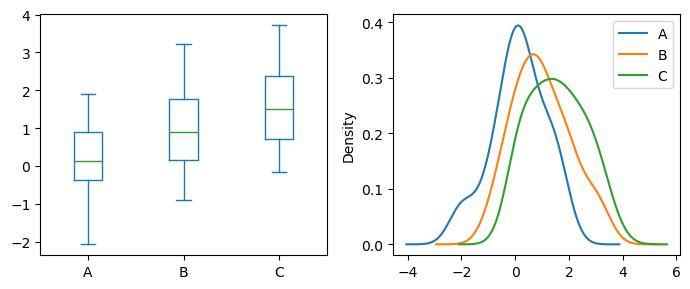

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

df.plot(kind='box', ax=ax[0])
df.plot(kind='kde', ax=ax[1])

fig.tight_layout()

## t-test

In [7]:
from scipy import stats

stats.ttest_ind(A, B)

Ttest_indResult(statistic=-4.098586734399003, pvalue=8.576613653309499e-05)

In [8]:
stats.ttest_ind(A, C)

Ttest_indResult(statistic=-6.889943346504257, pvalue=5.417835176865654e-10)

In [9]:
stats.ttest_ind(B, C)

Ttest_indResult(statistic=-2.702848964145432, pvalue=0.008104301927619174)

## 1-way ANOVA

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [10]:
F, p = stats.f_oneway(A, B, C)

In [11]:
F

23.533902104682596

In [12]:
p

1.3590719185638985e-09

## Tukey's HSD

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.tukey_hsd.html

In [13]:
hsd = stats.tukey_hsd(A, B, C)

In [14]:
hsd.statistic

array([[ 0.        , -0.84338966, -1.41372695],
       [ 0.84338966,  0.        , -0.57033729],
       [ 1.41372695,  0.57033729,  0.        ]])

In [15]:
hsd.pvalue

array([[1.00000000e+00, 2.26787268e-04, 6.66437017e-10],
       [2.26787268e-04, 1.00000000e+00, 1.82679298e-02],
       [6.66437017e-10, 1.82679298e-02, 1.00000000e+00]])

In [16]:
hsd._nobs

3

In [17]:
hsd._ntreatments

150

In [18]:
hsd._stand_err

0.14661287403767

## Xy, means

In [19]:
Xy = pd.concat([
    pd.DataFrame({'g': 'A', 'y': A}),
    pd.DataFrame({'g': 'B', 'y': B}),
    pd.DataFrame({'g': 'C', 'y': C})
])
Xy.sample(10).head()

,g,y
47,C,-0.049680
30,A,-0.009668
37,A,1.759028
40,A,0.066567
32,B,0.229241


In [20]:
Xy.groupby(['g']).mean()

,y
g,
A,0.139065
B,0.982454
C,1.552792


In [21]:
Xy['y'].mean()

0.8914368828670105

## Regression

In [22]:
X = Xy.drop(columns=['y'])
y = Xy['y']

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(X)

OneHotEncoder()

In [24]:
X = pd.DataFrame(
    ohe.transform(X).todense(), 
    columns=ohe.get_feature_names_out()
)
X

,g_A,g_B,g_C
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
145,0.0,0.0,1.0
146,0.0,0.0,1.0
147,0.0,0.0,1.0
148,0.0,0.0,1.0


In [25]:
y = Xy['y']
y.shape

(150,)

In [26]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X.drop(columns=['g_A']), y)

LinearRegression()

In [27]:
m.intercept_, m.coef_

(0.13906468043625642, array([0.84338966, 1.41372695]))

In [28]:
m.coef_

array([0.84338966, 1.41372695])

## Means vs coefficients

In [29]:
Xy.groupby(['g']).mean()

,y
g,
A,0.139065
B,0.982454
C,1.552792


In [30]:
m.coef_ + m.intercept_

array([0.98245434, 1.55279163])

## Test statistics vs coefficients

In [31]:
hsd.statistic

array([[ 0.        , -0.84338966, -1.41372695],
       [ 0.84338966,  0.        , -0.57033729],
       [ 1.41372695,  0.57033729,  0.        ]])

In [32]:
m.coef_ 

array([0.84338966, 1.41372695])

## Contrast coding

In [33]:
X = Xy.assign(
    AB=lambda d: np.select([d['g']=='A', d['g']=='B'], [-0.5, 0.5], default=0.0),
    AC=lambda d: np.select([d['g']=='A', d['g']=='C'], [-0.5, 0.5], default=0.0)
)[['AB', 'AC']]

y = Xy['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(0.8914368828670105, array([0.18203491, 1.3227095 ]))

In [34]:
X = Xy.assign(
    AvB=lambda d: np.select([d['g']=='A', d['g']=='B'], [-0.5, 0.5], default=0.0),
    ABvC=lambda d: np.select([d['g']=='C'], [0.5], default=-0.5)
)[['AvB', 'ABvC']]

y = Xy['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(1.0567755700112798, array([0.84338966, 0.99203212]))

In [35]:
X = Xy.assign(
    AvB=lambda d: np.select([d['g']=='A', d['g']=='B'], [-0.5, 0.5], default=0.0),
    ABvC=lambda d: np.select([d['g']=='C'], [0.5], default=-0.25)
)[['AvB', 'ABvC']]

y = Xy['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(0.8914368828670105, array([0.84338966, 1.3227095 ]))